In [1]:
# from zipfile import ZipFile
# file_name = '/content/IAM_dataset.zip'
# with ZipFile(file_name,'r') as zip:
#   zip.extractall('/content/drive/MyDrive/Datasets')
#   print('Done')


In [2]:
import numpy as np
import os
import glob

from random import *
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [3]:
d = {}
from subprocess import check_output
with open('/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/FormsIAMSmall.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

66


In [4]:
tmp = []
target_list = []
tempDict = {}
tempDict = d.copy()
print(tempDict)
path_to_files = os.path.join('/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    #print(image_name)
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    #print("Form Image :: ", form)
    tempDict = d.copy()
    for key in d.keys():
        if key == form:
            val = tempDict.get(key)
            if val:
               #print("Form mapped with key :: ", key, " :: ", str(val))
               target_list.append(str(val))
               del tempDict[key]

{'a01-000u': '000', 'a01-000x': '001', 'a01-003': '002', 'a01-003u': '000', 'a01-003x': '003', 'a01-007': '004', 'a01-007u': '000', 'a01-007x': '003', 'a01-011': '005', 'a01-011u': '000', 'a01-011x': '006', 'a01-014': '007', 'a01-014u': '000', 'a01-014x': '008', 'a01-020': '009', 'a01-020u': '000', 'a01-020x': '010', 'a01-026': '009', 'a01-026u': '000', 'a01-026x': '008', 'a01-030': '005', 'a01-030u': '000', 'a01-030x': '010', 'a01-038': '007', 'a01-038x': '011', 'a01-043': '012', 'a01-043u': '000', 'a01-043x': '011', 'a01-049': '012', 'a01-049u': '000', 'a01-049x': '000', 'a01-053': '013', 'a01-053u': '000', 'a01-053x': '014', 'a01-058': '013', 'a01-058u': '000', 'a01-058x': '014', 'a01-063': '013', 'a01-063u': '000', 'a01-063x': '015', 'a01-068u': '000', 'a01-072u': '000', 'a01-072x': '001', 'a01-077': '016', 'a01-077u': '000', 'a01-082u': '000', 'a01-087': '017', 'a01-087u': '000', 'a01-091': '016', 'a01-091u': '000', 'a01-096u': '000', 'a01-102': '016', 'a01-102u': '000', 'a01-107'

In [5]:
img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
#print(img_targets)
#print(img_files)
print(img_files.shape)
print(img_targets.shape)

(354,)
(354,)


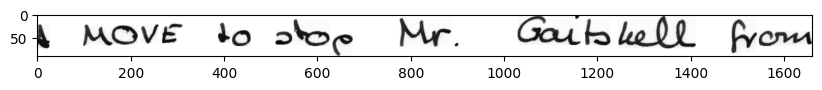

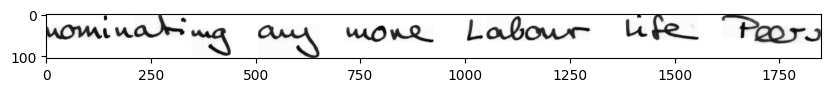

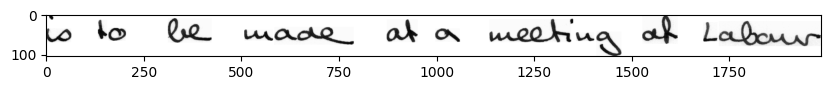

In [6]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [7]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:10], img_targets[:10], encoded_Y[:10])

['/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s00-00.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s00-01.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s00-02.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s00-03.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s01-00.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s01-01.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrittenTextExtraction/DataIAMFormSmall/a01-000u-s01-02.png'
 '/content/drive/MyDrive/Datasets/RIO_HandWrittenTextExtraction/RIO_HandWrit

In [8]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(233,) (60,) (61,)
(233,) (60,) (61,)


In [9]:
batch_size = 8
num_classes = 7

def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)


            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

# For training and testing, generator function is called with the intent of making train and test generator data.
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)


In [10]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

In [11]:
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation
#model.add(Lambda(lambda x: resize_image))

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes
print("Worked till here")

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())


Worked till here
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                       

In [12]:
nb_epoch = 2
samples_per_epoch = 233
nb_val_samples = 62

from keras.callbacks import ModelCheckpoint
filepath="model-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]


In [13]:
history_object = model.fit(train_generator,
                                     steps_per_epoch=samples_per_epoch,
                                      validation_data=validation_generator,
                                      validation_steps=nb_val_samples,
                                     epochs=nb_epoch, verbose=1,
                                     callbacks=callbacks_list)

<ipython-input-9-85e4dd8b5f32>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


Epoch 1/2
233/233 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9882
Epoch 1: saving model to model-01-0.0000.hdf5
233/233 [==============================] - 1360s 6s/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


233/233 [==============================] - ETA: 0s - loss: 9.8301e-05 - accuracy: 1.0000
Epoch 2: saving model to model-02-0.0000.hdf5
233/233 [==============================] - 1389s 6s/step - loss: 9.8301e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [15]:
model.load_weights('/content/model-02-0.0000.hdf5')
scores = model.evaluate_generator(test_generator,121) # 121 is the number of test images.
print("Accuracy = ", scores[1] , " ::" , len(scores))

<ipython-input-15-f0eeab50d00f>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator,121) # 121 is the number of test images.
<ipython-input-9-85e4dd8b5f32>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


Accuracy =  1.0  :: 2


In [16]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)

     cur_width = im.size[0]
     cur_height = im.size[1]

     print("Before Crop:", cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     print("After Crop:", now_width, now_height)
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
     print("Pick Number is ::", pick_num)

     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))

     X_test = np.array(images)

     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

print(X_test.shape)

Before Crop: 1989 96
After Crop: 2341 113
Pick Number is :: 222
Before Crop: 1718 85
After Crop: 2283 113
Pick Number is :: 217
Before Crop: 1875 92
After Crop: 2302 113
Pick Number is :: 218
Before Crop: 1966 88
After Crop: 2524 113
Pick Number is :: 241
Before Crop: 1205 78
After Crop: 1745 113
Pick Number is :: 163
Before Crop: 1878 81
After Crop: 2619 113
Pick Number is :: 250
Before Crop: 319 

<ipython-input-16-0693d3005e2f>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


54
After Crop: 667 113
Pick Number is :: 55
Before Crop: 2070 112
After Crop: 2088 113
Pick Number is :: 197
Before Crop: 1886 106
After Crop: 2010 113
Pick Number is :: 189
Before Crop: 1990 86
After Crop: 2614 113
Pick Number is :: 250
Before Crop: 1815 73
After Crop: 2809 113
Pick Number is :: 269
Before Crop: 1818 104
After Crop: 1975 113
Pick Number is :: 186
Before Crop: 1741 77
After Crop: 2554 113
Pick Number is :: 244
Before Crop: 475 62
After Crop: 865 113
Pick Number is :: 75
Before Crop: 1106 69
After Crop: 1811 113
Pick Number is :: 169
Before Crop: 449 66
After Crop: 768 113
Pick Number is :: 65
Before Crop: 1759 75
After Crop: 2650 113
Pick Number is :: 253
Before Crop: 1768 78
After Crop: 2561 113
Pick Number is :: 244
Before Crop: 1868 79
After Crop: 2671 113
Pick Number is :: 255
Before Crop: 1044 68
After Crop: 1734 113
Pick Number is :: 162
Before Crop: 1885 98
After Crop: 2173 113
Pick Number is :: 206
Before Crop: 1850 105
After Crop: 1990 113
Pick Number is :: 18

In [17]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
     predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

302/302 [==============================] - 4s 14ms/step
(9645, 7)
9645


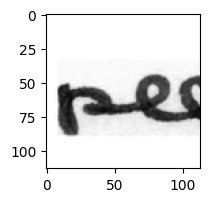

In [24]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    # print("okay1" + " " +  str(predicted_writer[i]) )
     if predicted_writer[i] == writer_number:
         image = X_test[i].squeeze()
         plt.figure(figsize=(2,2))
         plt.imshow(image, cmap ='gray')

image1 = X_test[1].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image1, cmap ='gray')
